In [2]:
import numpy as np
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, fetch_covtype, load_digits, make_blobs
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA as skPCA

In [2]:
def mosthighlycorrelated(mydataframe, numtoreport):
    cormatrix = mydataframe.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    print("Наилучшая корреляция:")
    print(cormatrix.head(numtoreport))
    print("Наихудшая корреляция:")
    print(cormatrix.tail(numtoreport))

In [3]:
def load_dataset(file_path):
  data = pd.read_csv(file_path, sep=',')
  data = np.array(data)
  X = data[:,1:-1]
  y = data[:,-1].astype(int)
  return (X, y)

In [4]:
class Rule(Enum):
  Kaiser = 1
  BSM = 2
  Scree = 3
  No = 4

In [5]:
def kaiser(eig_values):
    return eig_values[eig_values > eig_values.mean()].size

In [6]:
def BSM(eig_values):
  tr = eig_values.sum()
  n_eig_values = eig_values/tr
  stick = np.random.sample(eig_values.shape[0])
  stick = np.sort(stick/stick.sum())[::-1]
  return n_eig_values[n_eig_values > stick].size

In [7]:
def scree(eig_values):
  r = range(eig_values.shape[0])
  plt.plot(r, eig_values)
  plt.scatter(r, eig_values)
  plt.show()
  print("Enter number of components:")
  result = int(input())
  return result

In [8]:
map_rule_by_type = {
    Rule.BSM : BSM,
    Rule.Kaiser : kaiser,
    Rule.Scree : scree
}

In [9]:
class PCA(object):

  def __init__(self, rule = Rule.No):
    self.rule = rule

  def fit(self, X):
    mosthighlycorrelated(pd.DataFrame(X), 10)
    #covariation matrix of original components
    cov_matrix = np.cov(X.T)
    #cov_matrix visualisation
    sns.heatmap(cov_matrix, vmax=1., square=False).xaxis.tick_top()
    plt.show()
    # eigenvalues and eigenvectors calculation
    eig_val_cov, eig_vec_cov = np.linalg.eigh(cov_matrix)
    #list of pairs (value, vector)
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
    #sorting pairs by decreasing eigenvalues
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    #setting number of comp-s
    self.n_components = map_rule_by_type[self.rule](-np.sort(-eig_val_cov)) if self.rule != Rule.No else X.shape[1]
    #transformation matrix
    self.mat_w = np.array([ p[1] for p in eig_pairs])[:self.n_components]
  

  def report(self):
    print('Number of components {0} {1}'.format(self.n_components, self.rule))
    print(self.mat_w)

  def transform(self, X):
    X_center = X - X.mean(axis=0)
    #transfroming data
    return np.dot(X_center, self.mat_w.T)

In [10]:
def test_pca(X ,y):
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score, roc_auc_score
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

  clf = DecisionTreeClassifier(random_state=42, max_depth=20)
  clf.fit(X_train, y_train)
  preds = clf.predict_proba(X_test)
  print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                  preds.argmax(axis=1))))

In [11]:
def apply_dataset(X,y, rule =Rule.No):
  pca_ = PCA(rule=rule)
  pca_.fit(X)
  pca_.report()
  my_pca_X = pca_.transform(X)
  test_pca(my_pca_X, y)

In [12]:
def for_all_rules(X, y):
  for rule in [Rule.No, Rule.Kaiser, Rule.BSM, Rule.Scree ]:
    apply_dataset(X, y, rule)

## BREAST CANCER - 30 variables, 2 classes

In [13]:
X, y = load_breast_cancer(return_X_y=True)
X.shape
X = StandardScaler().fit_transform(X)
X.shape


(569, 30)

(30, 30)

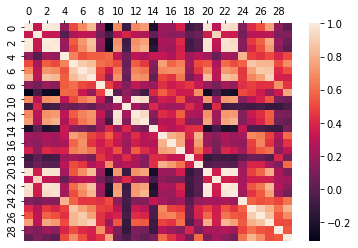

In [14]:
covmat = np.cov(X.T);
sns.heatmap(covmat, vmax=1., square=False).xaxis.tick_top()
covmat.shape

In [15]:
bc = load_breast_cancer()
bc.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

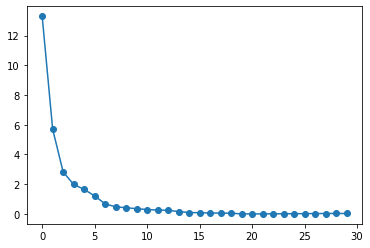

Enter number of components:


In [16]:
vals, _ = np.linalg.eig(covmat)
kKaiser = kaiser(vals)
kBSM = BSM(vals)
kScree = scree(vals)

In [17]:
[kKaiser, kBSM, kScree]

[6, 4, 3]

In [1]:
def report_by_rule(n, index):
    
    pca = skPCA(n_components = n)
    XPCAreduced = pca.fit_transform(X)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_matrix = pd.DataFrame(loadings, columns=['PC'+ str(i+1) for i in range(pca.n_components)], index=index)
    # print(loadings_matrix.to_markdown())
    array = pca.components_.T
    names = index.copy()
    larrray = np.sum(array, axis=1).tolist()
    larrray, names = zip(*sorted(zip(larrray, names), reverse=True))
    ranged_features = pd.DataFrame(larrray, columns=["Суммарная нагрузка"], index=names)
    print(ranged_features.to_markdown())
    restmat = covmat - np.cov(pca.components_.T)
    rest = pd.DataFrame(restmat, columns=index, index=index)
    print(rest.to_markdown())

In [19]:
report_by_rule(kKaiser)

|                         |   mean radius |   mean texture |   mean perimeter |   mean area |   mean smoothness |   mean compactness |   mean concavity |   mean concave points |   mean symmetry |   mean fractal dimension |   radius error |   texture error |   perimeter error |   area error |   smoothness error |   compactness error |   concavity error |   concave points error |   symmetry error |   fractal dimension error |   worst radius |   worst texture |   worst perimeter |   worst area |   worst smoothness |   worst compactness |   worst concavity |   worst concave points |   worst symmetry |   worst fractal dimension |
|:------------------------|--------------:|---------------:|-----------------:|------------:|------------------:|-------------------:|-----------------:|----------------------:|----------------:|-------------------------:|---------------:|----------------:|------------------:|-------------:|-------------------:|--------------------:|------------------:|------------

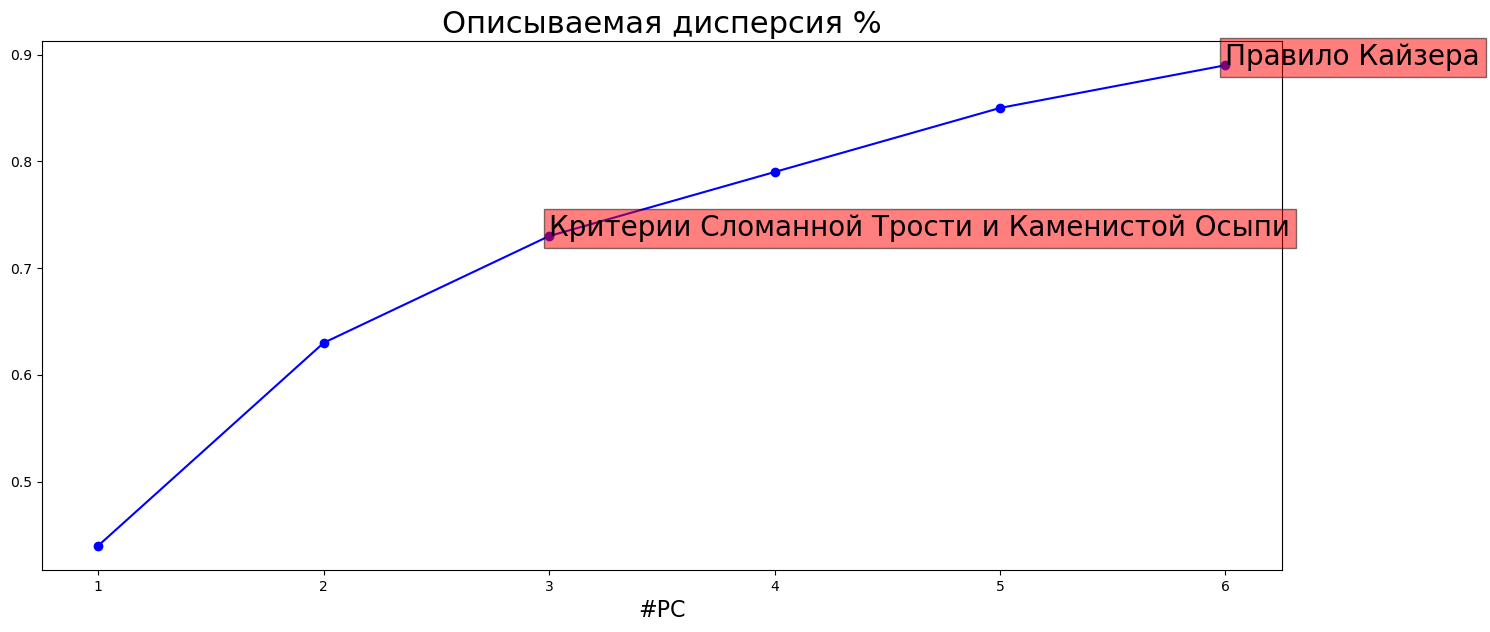

In [151]:
pca = skPCA(n_components=kKaiser)
pca.fit_transform(X)
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum,'bo-')
plt.title('Описываемая дисперсия %', fontsize=22)
plt.xlabel('#PC', fontsize=16)
plt.text(kKaiser-1, variance_exp_cumsum[kKaiser-1], "Правило Кайзера",size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.text(kBSM-1, variance_exp_cumsum[kBSM-1], "Критерии Сломанной Трости и Каменистой Осыпи", size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(ticks=[i for i, _ in enumerate(variance_exp_cumsum)],labels=[i+1 for i, _ in enumerate(variance_exp_cumsum)])
plt.show()

In [148]:
[variance_exp_cumsum]

[array([0.44, 0.63, 0.73, 0.79, 0.85, 0.89])]

## DIGITS DATASET - 64 vars, 10 classes

In [20]:
X, y = load_digits(return_X_y=True)
X = StandardScaler().fit_transform(X)

(64, 64)

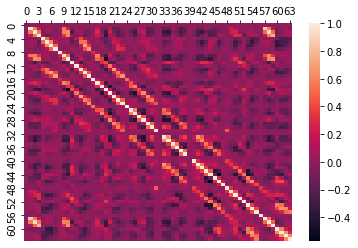

In [21]:
covmat = np.cov(X.T);
sns.heatmap(covmat, vmax=1., square=False).xaxis.tick_top()
covmat.shape

In [30]:
mnist = load_digits()
mnist.feature_names

['pixel_0_0',
 'pixel_0_1',
 'pixel_0_2',
 'pixel_0_3',
 'pixel_0_4',
 'pixel_0_5',
 'pixel_0_6',
 'pixel_0_7',
 'pixel_1_0',
 'pixel_1_1',
 'pixel_1_2',
 'pixel_1_3',
 'pixel_1_4',
 'pixel_1_5',
 'pixel_1_6',
 'pixel_1_7',
 'pixel_2_0',
 'pixel_2_1',
 'pixel_2_2',
 'pixel_2_3',
 'pixel_2_4',
 'pixel_2_5',
 'pixel_2_6',
 'pixel_2_7',
 'pixel_3_0',
 'pixel_3_1',
 'pixel_3_2',
 'pixel_3_3',
 'pixel_3_4',
 'pixel_3_5',
 'pixel_3_6',
 'pixel_3_7',
 'pixel_4_0',
 'pixel_4_1',
 'pixel_4_2',
 'pixel_4_3',
 'pixel_4_4',
 'pixel_4_5',
 'pixel_4_6',
 'pixel_4_7',
 'pixel_5_0',
 'pixel_5_1',
 'pixel_5_2',
 'pixel_5_3',
 'pixel_5_4',
 'pixel_5_5',
 'pixel_5_6',
 'pixel_5_7',
 'pixel_6_0',
 'pixel_6_1',
 'pixel_6_2',
 'pixel_6_3',
 'pixel_6_4',
 'pixel_6_5',
 'pixel_6_6',
 'pixel_6_7',
 'pixel_7_0',
 'pixel_7_1',
 'pixel_7_2',
 'pixel_7_3',
 'pixel_7_4',
 'pixel_7_5',
 'pixel_7_6',
 'pixel_7_7']

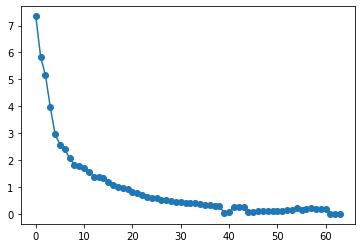

Enter number of components:


In [24]:
vals, _ = np.linalg.eig(covmat)
kKaiser = kaiser(vals)
kBSM = BSM(vals)
kScree = scree(vals)

In [42]:
[kKaiser, kBSM, kScree]

[19, 14, 6]

In [ ]:
report_by_rule(kScree,mnist.feature_names)

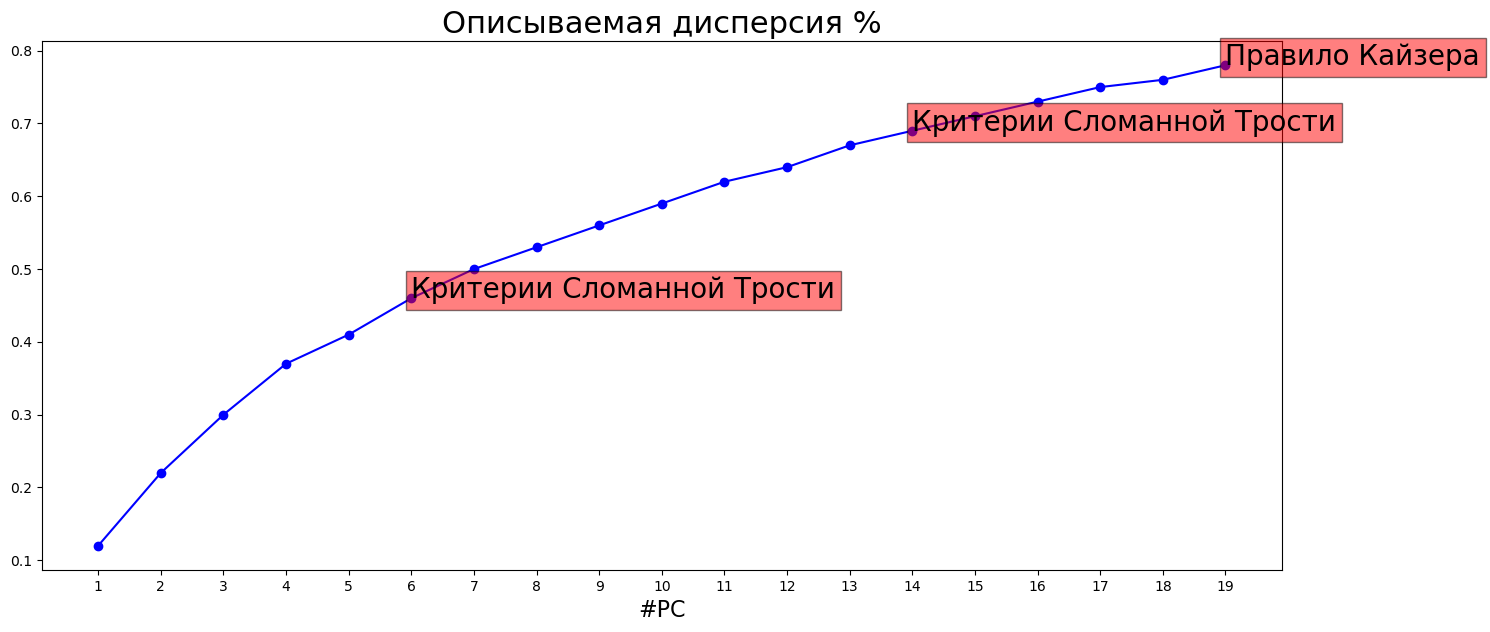

In [45]:
pca = skPCA(n_components=kKaiser)
pca.fit_transform(X)
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum,'bo-')
plt.title('Описываемая дисперсия %', fontsize=22)
plt.xlabel('#PC', fontsize=16)
plt.text(kKaiser-1, variance_exp_cumsum[kKaiser-1], "Правило Кайзера",size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.text(kBSM-1, variance_exp_cumsum[kBSM-1], "Критерии Сломанной Трости", size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.text(kScree-1, variance_exp_cumsum[kScree-1], "Критерии Сломанной Трости", size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(ticks=[i for i, _ in enumerate(variance_exp_cumsum)],labels=[i+1 for i, _ in enumerate(variance_exp_cumsum)])
plt.show()

## Custom dataset - 1000 vars, 20 classes

In [3]:
X, y = make_blobs(n_samples=500, n_features=600, centers=20, cluster_std=2)
X = StandardScaler().fit_transform(X)

In [4]:
kKaiser = 19
kBSM = 19
kScree = 13

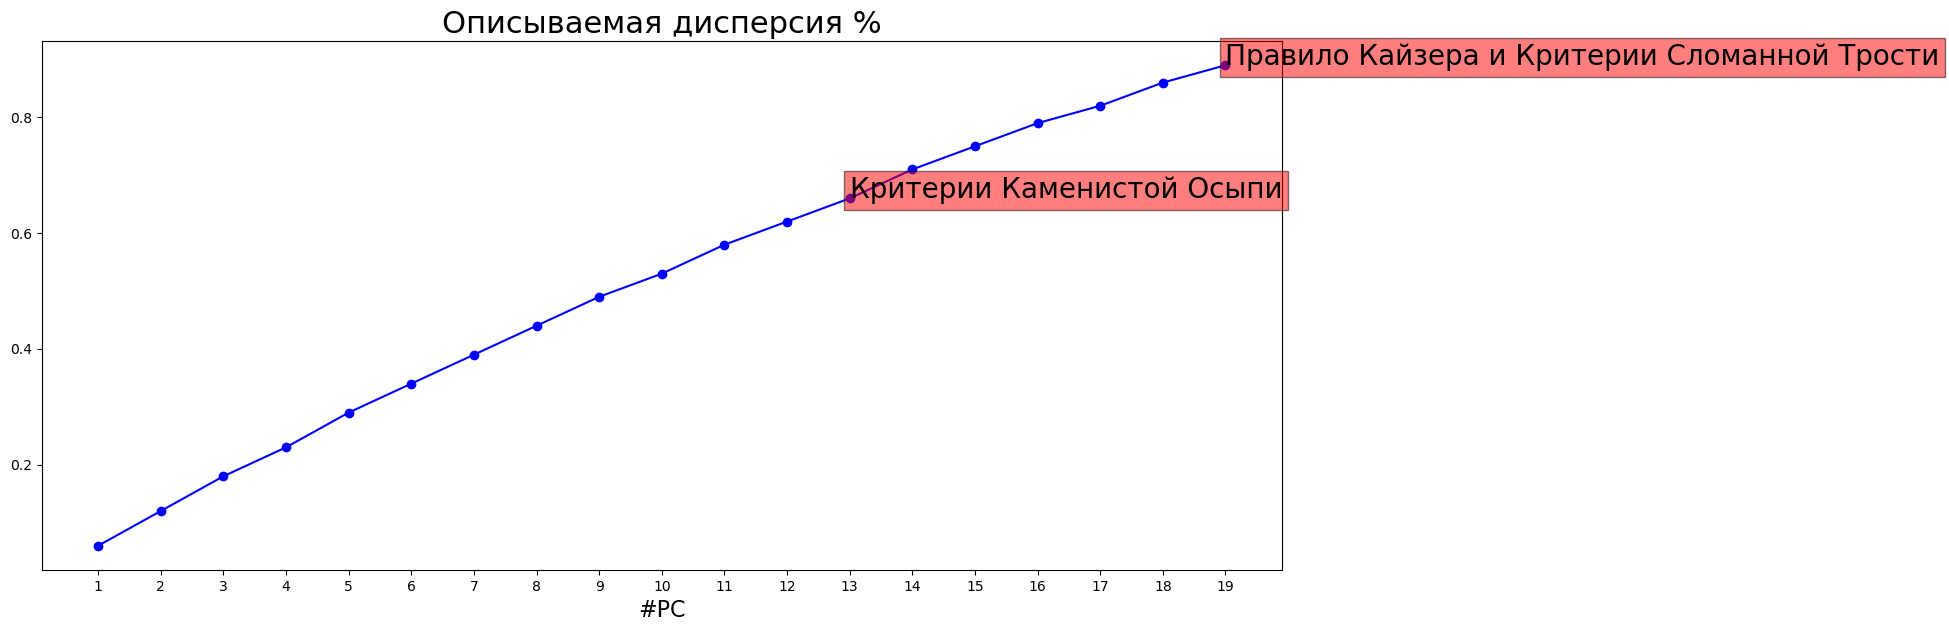

In [5]:
pca = skPCA(n_components=kKaiser)
pca.fit_transform(X)
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum,'bo-')
plt.title('Описываемая дисперсия %', fontsize=22)
plt.xlabel('#PC', fontsize=16)
plt.text(kKaiser-1, variance_exp_cumsum[kKaiser-1], "Правило Кайзера и Критерии Сломанной Трости",size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.text(kScree-1, variance_exp_cumsum[kScree-1], "Критерии Каменистой Осыпи", size=20, bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(ticks=[i for i, _ in enumerate(variance_exp_cumsum)],labels=[i+1 for i, _ in enumerate(variance_exp_cumsum)])
plt.show()